In [105]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

from scipy.stats import beta

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.feature_selection import RFECV

from sklearn.metrics import log_loss, accuracy_score, brier_score_loss

In [106]:
def update_beta(swing_col):
    """
    a function that updates the alpha and beta params of the beta-binomial
    to give a bayesian estimate of a player's swing perc
    """
    a, b = 5, 5
    expected_swing_pct_list = []
    
    for swing in swing_col:
        expected_swing_pct_list.append(beta(a, b).mean())
        if swing == 1:
            a += 1
        else:
            b += 1
    return pd.Series(expected_swing_pct_list, index=swing_col.index)

In [107]:
# excluding columns with data that can only be known after a swing
# has or hasn't occurred
post_swing_cols = ['hc_x', 'hc_y', 'hit_location', 'launch_speed', 'launch_angle', 'babip_value',
                    'iso_value', 'woba_value', 'woba_denom', 'launch_speed_angle', 'post_away_score',
                    'post_home_score', 'post_fld_score', 'post_bat_score', 'delta_run_exp',
                    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'events',
                    'type', 'delta_home_win_exp', 'bb_type', 'hit_distance_sc', 'description',
                    'des']

# columns with id or redundant info. names excluded rather because 
# than id numbers because there are duplicates. umpire, spin_dir are null
useless_or_null_cols = ['pitch_uid', 'game_pk', 'sv_id', 'pitcher_name', 'batter_name', 'umpire', 
                        'spin_dir', 'pitcher.1', 'fielder_2.1', 'fielder_2', 'fielder_3', 'fielder_4',
                        'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9']

df = pd.read_csv('train.csv', usecols=lambda x: x not in post_swing_cols and x not in useless_or_null_cols)
df = df.sort_values(by='game_date').reset_index(drop=True)

df.head()

,game_date,pitcher,batter,pitch_type,release_speed,release_pos_x,release_pos_z,zone,game_type,stand,...,pitch_name,home_score,away_score,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,attack_zone,swing
0,2020-07-23,592767,605141,FC,88.8,2.13,6.49,13.0,R,R,...,Cutter,1,1,1,1,Infield shift,Standard,144.0,chase,0
1,2020-07-23,543037,519346,SL,90.4,-1.92,5.59,14.0,R,L,...,Slider,1,2,1,2,Infield shift,Standard,162.0,waste,0
2,2020-07-23,543037,519346,KC,85.3,-1.95,5.64,14.0,R,L,...,Knuckle Curve,1,2,1,2,Infield shift,Standard,48.0,shadow,1
3,2020-07-23,453286,650402,FF,94.2,-3.17,5.38,12.0,R,R,...,4-Seam Fastball,1,3,3,1,Infield shift,Standard,219.0,chase,0
4,2020-07-23,453286,650402,SL,84.0,-3.44,5.20,14.0,R,R,...,Slider,1,3,3,1,Infield shift,Standard,112.0,waste,0


In [134]:
# engineering a few features
# maybe players swing conditional on a lead/deficit
df['score_differential'] = df['bat_score'].sub(df['fld_score'])

# maybe total movement matters more than decomposed movement
df['total_catcher_movement'] = np.sqrt(df['pfx_x'] ** 2 + df['pfx_z'] ** 2)

# a larger strike zone seems like it would force more swinging
df['total_strike_zone'] = df['sz_top'].sub(df['sz_bot'])

# month? some proxy for temperature. who knows?
df['game_date'] = pd.to_datetime(df['game_date'])
df['month'] = df['game_date'].dt.month
df['year_month'] = df['game_year'].astype(str) + '_' + df['month'].astype(str)

# converting strikes and balls to a 'count' category, might help
df['count'] = df['strikes'].astype(str) + '_' + df['balls'].astype(str)
df['count'] = df['count'].astype('category')

# simple binaries for above/below strike zone
df['above_sztop'] = (df['sz_top'] <= df['plate_z']).astype(int)
df['below_szbot'] = (df['sz_bot'] >= df['plate_z']).astype(int)

# simple binary for 'over plate' when it crosses plate
df['over_plate'] = abs(df['plate_x']) <= 0.83

In [109]:
# since the dataset game_dates do not overlap, i'll create some expanding statistics
# for each player. i will fillna as if i know nothing and use only the expanding
# swing percentage to date in the dataset(s)

df['batter_swing_perc'] = (
    df
    .groupby('batter')['swing']
    .transform(lambda x: x.shift().expanding(min_periods=30).mean())
)

df['pitcher_swing_perc'] = (
    df
    .groupby('pitcher')['swing']
    .transform(lambda x: x.shift().expanding(min_periods=30).mean())
)

pfx_x, pfx_z = horizonal_movement_catcher, vertical_movement_catcher
plate_x, plate_z = horizontal_position_plate, vertical_position_plate5
sz_top, sz_bot = strike_zone_top, strike_zone_bottom
vx0, vy0, vz0 = velocity_in_x, velocity_in_y, velocity_in_z
ax, ay, az = acceleration_in_x, velocity_in_y, velocity_in_z

In [54]:
# checking the summary stats of a few columns
df[['sz_top', 'sz_bot', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z']].describe().T

,count,mean,std,min,25%,50%,75%,max
sz_top,1443276.0,3.389314,0.173289,2.50,3.30,3.40,3.49,4.47
sz_bot,1443276.0,1.585643,0.098063,0.77,1.53,1.59,1.64,2.29
plate_x,1443276.0,0.042901,0.845338,-8.41,-0.53,0.04,0.61,9.11
plate_z,1443276.0,2.274539,0.979735,-5.07,1.64,2.28,2.92,13.58
pfx_x,1443276.0,-0.117368,0.869179,-2.87,-0.85,-0.19,0.58,2.84
pfx_z,1443276.0,0.643119,0.750901,-2.13,0.18,0.74,1.27,2.80


In [124]:
# figuring out what zones mean
df.groupby('zone').agg({'plate_x' : ['min', 'max'],
                        'plate_z' : ['min', 'max']})

plate_x       plate_z       
         min   max     min    max
zone                             
1.0    -0.83 -0.28    2.07   4.30
2.0    -0.28  0.28    2.14   4.13
3.0     0.28  0.83    2.21   4.15
4.0    -0.83 -0.28    1.61   3.58
5.0    -0.28  0.28    1.60   3.45
6.0     0.28  0.83    1.52   3.34
7.0    -0.83 -0.28    1.13   2.66
8.0    -0.28  0.28    1.07   2.60
9.0     0.28  0.83    1.07   2.66
11.0   -8.41  0.00    1.93  13.58
12.0    0.00  9.11    1.84   8.82
13.0   -5.39  0.00   -5.07   2.98
14.0    0.00  8.83   -4.98   3.09

<Axes: xlabel='game_year,month'>

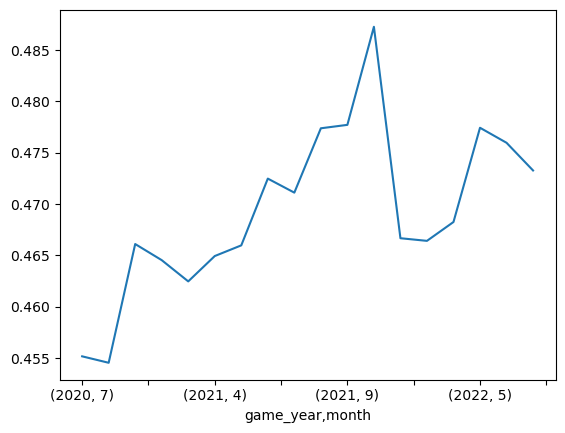

In [133]:
# looking at the swing % over game year and month
df.groupby(['game_year', 'month'])['swing'].mean().plot()

In [101]:
# using mutual information to select features
mi_class = (
    mutual_info_classif(
        df.select_dtypes('number').drop(columns='swing').dropna(),
        df.select_dtypes('number').dropna().loc[:,'swing'])
)

kbest = SelectKBest(mi_class, k=10)

In [110]:
X = df.drop(columns=['swing', 'game_date']).copy()
y = df['swing']

X_train, X_test = X.iloc[:1000000].copy(), X.iloc[1000000:].copy()
y_train, y_test = y.iloc[:1000000].copy(), y.iloc[1000000:].copy()

In [111]:
cat_columns = X_train.select_dtypes(exclude='number').columns
cat_indices = [X_train.columns.get_loc(col) for col in cat_columns]

model = HistGradientBoostingClassifier(categorical_features=cat_indices)
cat_model = CatBoostClassifier()

pipeline = make_pipeline(
    OrdinalEncoder(unknown_value=9999999, handle_unknown='use_encoded_value'),
    model
)

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)

In [120]:
p =permutation_importance(
    pipeline,
    X_test, y_test,
    n_repeats=5,
    scoring='neg_log_loss',
    max_samples=0.1, 
    random_state=44
)

imp_df = (
    pd.DataFrame(
        {'feature' : X_test.columns,
         'importance_mean' : p['importances_mean'],
         'importance_std' : p['importances_std']})
)

In [124]:
imp_df.sort_values(by='importance_mean', ascending=False)

,feature,importance_mean,importance_std
50,total_strike_zone,0.204864,0.004688
32,sz_bot,0.160519,0.002130
6,zone,0.059810,0.000771
47,attack_zone,0.045042,0.001028
17,plate_x,0.038623,0.000640
13,strikes,0.026359,0.000780
52,count,0.019368,0.000324
18,plate_z,0.015661,0.000464
15,pfx_x,0.012920,0.000313
31,sz_top,0.010483,0.000456
